# Malicious URL Detection

[Data Source](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)

In [1]:
import string
import re

from nltk.corpus import words

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

from scipy import stats

from pycm import ConfusionMatrix

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv("data/malicious_phish.csv", header=0)
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
df["type"].value_counts(normalize=True)

type
benign        0.657415
defacement    0.148124
phishing      0.144521
malware       0.049939
Name: proportion, dtype: float64

In [5]:
def separate_http(text):
    if "http://" in text:
        return -1
    if "https://" in text:
        return 1
    else:
        return 0

In [6]:
df["encrypted"] = df["url"].copy().apply(separate_http)

In [7]:
df["encrypted"].value_counts(normalize=True)

encrypted
 0    0.711303
-1    0.264720
 1    0.023978
Name: proportion, dtype: float64

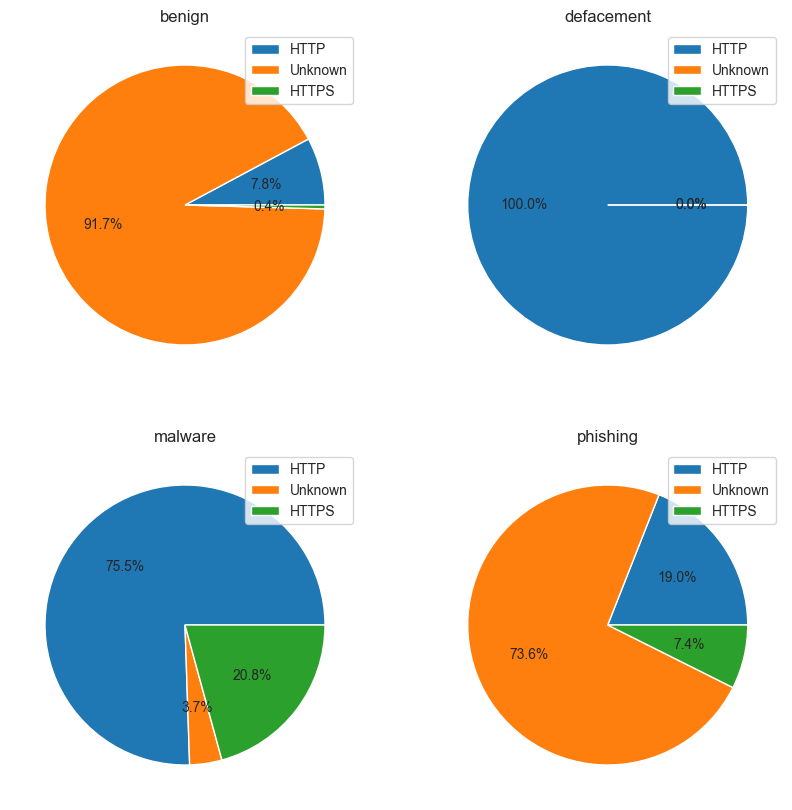

In [8]:
grouped = df.groupby("type")["encrypted"].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (group, counts) in enumerate(grouped.iterrows()):
    renamed_labels = ["HTTP", "Unknown", "HTTPS"]
    axes[idx].pie(counts, labels=None, autopct="%1.1f%%", labeldistance=1.1)
    axes[idx].set_title(f"{group}")
    axes[idx].legend(renamed_labels, loc="upper right")

for ax in axes[len(grouped):]:
    ax.axis("off")

plt.show()

In [9]:
def count_letters(text):
   return len(list(filter(lambda c: c in string.ascii_letters, text)))

In [10]:
def count_other_symbols(text):
   return len(list(filter(lambda c: c not in string.ascii_letters, text)))

In [11]:
df["letter_count"] = df["url"].copy().apply(count_letters)

In [12]:
df["count_symbols"] = df["url"].copy().apply(count_other_symbols)

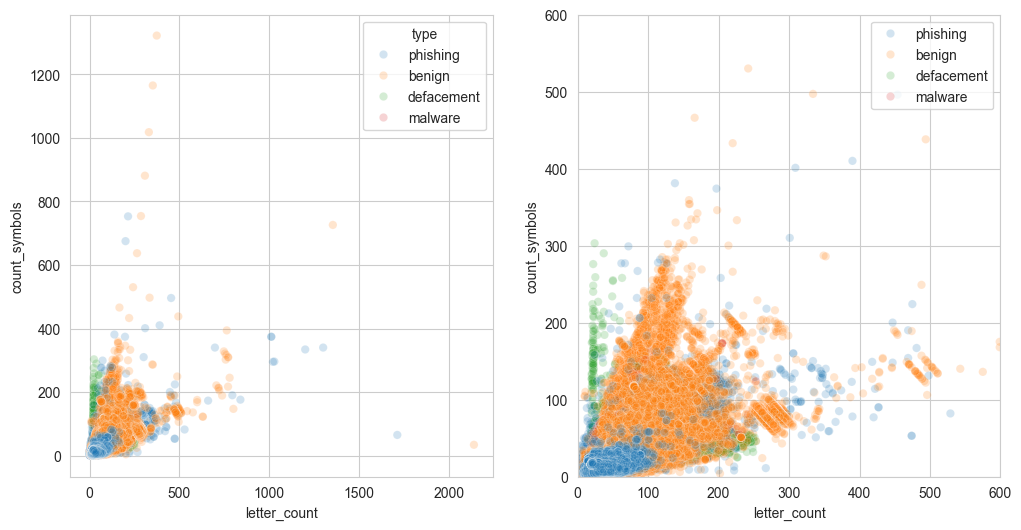

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax2.set_xlim(0, 600)
ax2.set_ylim(0, 600)

sns.scatterplot(
    data=df,
    x="letter_count",
    y="count_symbols",
    hue="type",
    alpha=0.2,
    ax=ax1
)

sns.scatterplot(
    data=df,
    x="letter_count",
    y="count_symbols",
    hue="type",
    alpha=0.2,
    ax=ax2
)

plt.legend(loc="upper right")

In [14]:
def count_symbol(text, symbol):
   return text.count(symbol)

In [15]:
symbols = ["=", "\\", "&", "%", "$", "-", "?", "/", ";"]

for symbol in symbols:
    df[f"count_{symbol}"] = df["url"].copy().apply(lambda x: count_symbol(x, symbol))

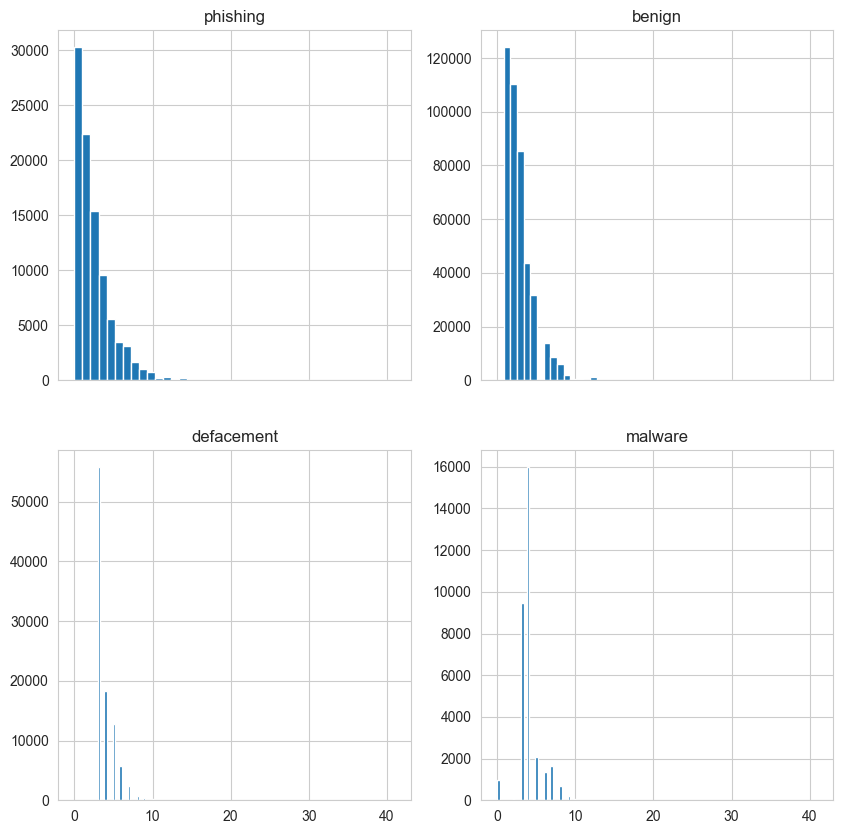

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
axes = axes.flatten()

for idx, url_type in enumerate(df["type"].unique()):
    sub_df = df[df["type"] == url_type]
    axes[idx].hist(sub_df["count_/"], bins=40)
    axes[idx].set_title(f"{url_type}")

for ax in axes[len(grouped):]:
    ax.axis("off")

plt.show()

In [17]:
df["contains_ip"] = df["url"].apply(
    lambda x: re.findall(r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b", x)
).apply(
    lambda x: False if x == [] else True
)

In [18]:
df

,url,type,encrypted,letter_count,count_symbols,count_=,count_\,count_&,count_%,count_$,count_-,count_?,count_/,count_;,contains_ip
0,br-icloud.com.br,phishing,0,13,3,0,0,0,0,0,1,0,0,0,False
1,mp3raid.com/music/krizz_kaliko.html,benign,0,29,6,0,0,0,0,0,0,0,2,0,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,25,6,0,0,0,0,0,0,0,3,0,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,-1,63,25,4,0,3,0,0,1,1,3,0,False
4,http://adventure-nicaragua.net/index.php?optio...,defacement,-1,199,36,3,0,2,0,0,1,1,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,21,18,0,0,0,0,0,0,0,3,0,False
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,29,15,0,0,0,0,0,2,0,4,0,False
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,33,9,0,0,0,0,0,0,0,4,0,False
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,36,9,0,0,0,0,0,0,0,2,0,False


In [19]:
df.groupby("type")["contains_ip"].value_counts().unstack(fill_value=0)

contains_ip,False,True
type,,
benign,427932,171
defacement,96457,0
malware,20732,11788
phishing,93702,409


In [20]:
df["digit_to_letter_ratio"] = df["url"].apply(lambda x: len(re.sub("[^0-9]", "", x)) + 1).div((df["letter_count"] + 1), axis=0)
df

,url,type,encrypted,letter_count,count_symbols,count_=,count_\,count_&,count_%,count_$,count_-,count_?,count_/,count_;,contains_ip,digit_to_letter_ratio
0,br-icloud.com.br,phishing,0,13,3,0,0,0,0,0,1,0,0,0,False,0.071429
1,mp3raid.com/music/krizz_kaliko.html,benign,0,29,6,0,0,0,0,0,0,0,2,0,False,0.066667
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,25,6,0,0,0,0,0,0,0,3,0,False,0.076923
3,http://www.garage-pirenne.be/index.php?option=...,defacement,-1,63,25,4,0,3,0,0,1,1,3,0,False,0.125000
4,http://adventure-nicaragua.net/index.php?optio...,defacement,-1,199,36,3,0,2,0,0,1,1,3,0,False,0.115000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,21,18,0,0,0,0,0,0,0,3,0,False,0.590909
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,29,15,0,0,0,0,0,2,0,4,0,False,0.266667
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,33,9,0,0,0,0,0,0,0,4,0,False,0.117647
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,36,9,0,0,0,0,0,0,0,2,0,False,0.027027


In [21]:
df["contains_%20"] = df["url"].apply(lambda x: "%20" in x)
df

,url,type,encrypted,letter_count,count_symbols,count_=,count_\,count_&,count_%,count_$,count_-,count_?,count_/,count_;,contains_ip,digit_to_letter_ratio,contains_%20
0,br-icloud.com.br,phishing,0,13,3,0,0,0,0,0,1,0,0,0,False,0.071429,False
1,mp3raid.com/music/krizz_kaliko.html,benign,0,29,6,0,0,0,0,0,0,0,2,0,False,0.066667,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,25,6,0,0,0,0,0,0,0,3,0,False,0.076923,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,-1,63,25,4,0,3,0,0,1,1,3,0,False,0.125000,False
4,http://adventure-nicaragua.net/index.php?optio...,defacement,-1,199,36,3,0,2,0,0,1,1,3,0,False,0.115000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,21,18,0,0,0,0,0,0,0,3,0,False,0.590909,False
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,29,15,0,0,0,0,0,2,0,4,0,False,0.266667,False
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,33,9,0,0,0,0,0,0,0,4,0,False,0.117647,False
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,36,9,0,0,0,0,0,0,0,2,0,False,0.027027,False


In [22]:
df.groupby("type")["contains_%20"].value_counts().unstack(fill_value=0)

contains_%20,False,True
type,,
benign,422879,5224
defacement,96457,0
malware,32148,372
phishing,93522,589


In [23]:
word_set = set(words.words())

df["count_english_words"] = df["url"].apply(
    lambda x: [word for word in re.split("[^a-zA-Z]", x) if word != ""]
).apply(
    lambda x: sum(word in word_set for word in x)
)

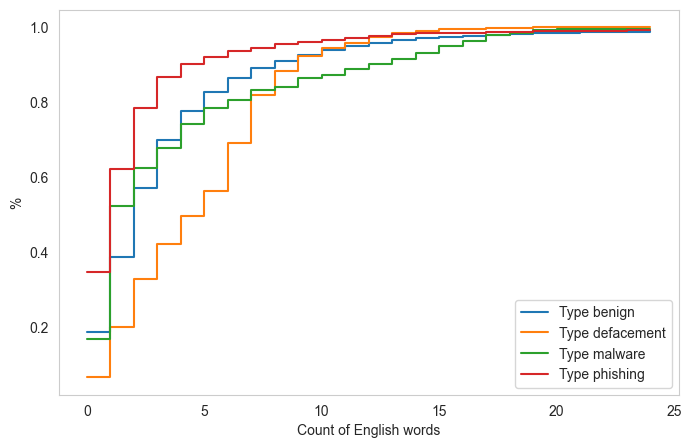

In [24]:
cdf_data = df.groupby("type")["count_english_words"].value_counts(normalize=True).unstack(fill_value=0).cumsum(axis=1)
x_range = np.arange(0, 25)

plt.figure(figsize=(8, 5))
for type_, counts in cdf_data.iterrows():
    y_values = counts.reindex(x_range, fill_value=0).values.tolist()
    plt.step(x_range, y_values, where="post", label=f"Type {type_}")

plt.xlabel("Count of English words")
plt.ylabel("%")
plt.legend()
plt.grid()
plt.show()

In [25]:
for column in df:
    unique_values = df[column].unique()
    count_unique_values = len(unique_values)
    if count_unique_values < 15:
        print(f"{column:15}  {count_unique_values:5} | {unique_values}")

type                 4 | ['phishing' 'benign' 'defacement' 'malware']
encrypted            3 | [ 0 -1  1]
count_$              7 | [0 1 2 5 4 6 3]
contains_ip          2 | [False  True]
contains_%20         2 | [False  True]


In [26]:
df.isnull().sum()

url                      0
type                     0
encrypted                0
letter_count             0
count_symbols            0
count_=                  0
count_\                  0
count_&                  0
count_%                  0
count_$                  0
count_-                  0
count_?                  0
count_/                  0
count_;                  0
contains_ip              0
digit_to_letter_ratio    0
contains_%20             0
count_english_words      0
dtype: int64

In [28]:
for col in df.select_dtypes(include=["bool"]):
    df[col] = df[col].astype(np.int64)

In [29]:
def get_num_outliers(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    return sum((col < q1) | (col > q3))

for col in df.select_dtypes(include=["int64"]):
    print(f"{col}: {get_num_outliers(df[col])}")

encrypted: 15614
letter_count: 306989
count_symbols: 275246
count_=: 140293
count_\: 3879
count_&: 85513
count_%: 27200
count_$: 96
count_-: 125733
count_?: 140178
count_/: 264939
count_;: 11045
contains_ip: 12368
contains_%20: 6185
count_english_words: 286270


In [30]:
scaler = StandardScaler()
columns_to_scale = [col for col in df.columns if "count" in col]

for col in columns_to_scale:
    # df[col] = df[col]  / df[col].abs().max()
    df[col] = stats.zscore(df[col])

In [31]:
for col in df.select_dtypes(include=["int64"]):
    print(f"{col}: {get_num_outliers(df[col])}")

encrypted: 15614
contains_ip: 12368
contains_%20: 6185


In [32]:
df

,url,type,encrypted,letter_count,count_symbols,count_=,count_\,count_&,count_%,count_$,count_-,count_?,count_/,count_;,contains_ip,digit_to_letter_ratio,contains_%20,count_english_words
0,br-icloud.com.br,phishing,0,-1.019490,-0.682877,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,-0.185091,-0.507190,-1.549358,-0.069621,0,0.071429,0,-0.717380
1,mp3raid.com/music/krizz_kaliko.html,benign,0,-0.513389,-0.511105,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,-0.521362,-0.507190,-0.499040,-0.069621,0,0.066667,0,-0.305466
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,-0.639914,-0.511105,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,-0.521362,-0.507190,0.026119,-0.069621,0,0.076923,0,-0.717380
3,http://www.garage-pirenne.be/index.php?option=...,defacement,-1,0.562076,0.576785,2.238780,-0.054681,2.139824,-0.116422,-0.01011,-0.185091,1.759256,0.026119,-0.069621,0,0.125000,0,0.930276
4,http://adventure-nicaragua.net/index.php?optio...,defacement,-1,4.863936,1.206616,1.579567,-0.054681,1.322942,-0.116422,-0.01011,-0.185091,1.759256,0.026119,-0.069621,0,0.115000,0,1.136233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,-0.766439,0.175983,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,-0.521362,-0.507190,0.026119,-0.069621,0,0.590909,0,-0.717380
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,-0.513389,0.004211,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,0.151181,-0.507190,0.551278,-0.069621,0,0.266667,0,-0.511423
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,-0.386863,-0.339333,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,-0.521362,-0.507190,0.551278,-0.069621,0,0.117647,0,-0.511423
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,-0.291969,-0.339333,-0.398075,-0.054681,-0.310821,-0.116422,-0.01011,-0.521362,-0.507190,-0.499040,-0.069621,0,0.027027,0,0.106448


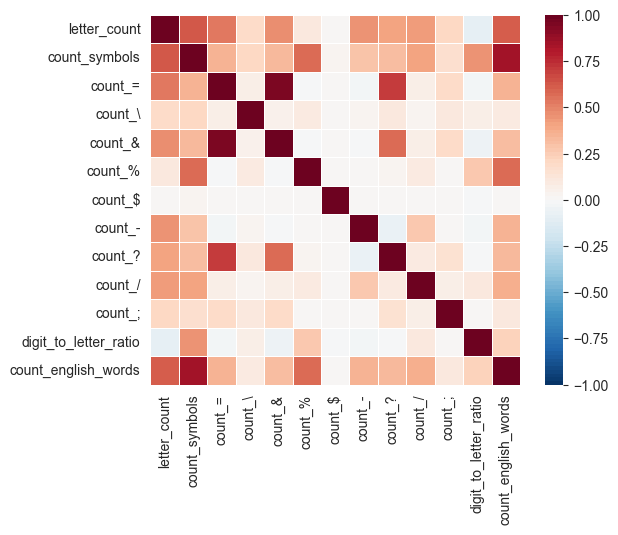

In [71]:
sns.heatmap(
    df.select_dtypes(include=["float64"]).corr(),
    vmin=-1,
    vmax=1,
    square=True,
    cmap=sns.color_palette("RdBu_r", 100),
    linewidths=.5
)
plt.show()

## Classification

In [34]:
x_columns = [col for col in df.columns.tolist() if col not in ["url", "type"]]
y_column = "type"

X = df[x_columns]
y = df[y_column]

In [35]:
rus = RandomUnderSampler(random_state=13)
X, y = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=13)

In [36]:
logistic_regression = LogisticRegression(random_state=13, max_iter=10000)

cv_results = cross_validate(logistic_regression, X_train, y_train, cv=5, return_estimator=True)

In [37]:
coefs = np.array([estimator.coef_[0] for estimator in cv_results["estimator"]])

In [38]:
cv_results["test_score"]

array([0.69062605, 0.68860808, 0.68995339, 0.6906741 , 0.68177013])

In [39]:
best_estimator_index = np.argmax(cv_results["test_score"])

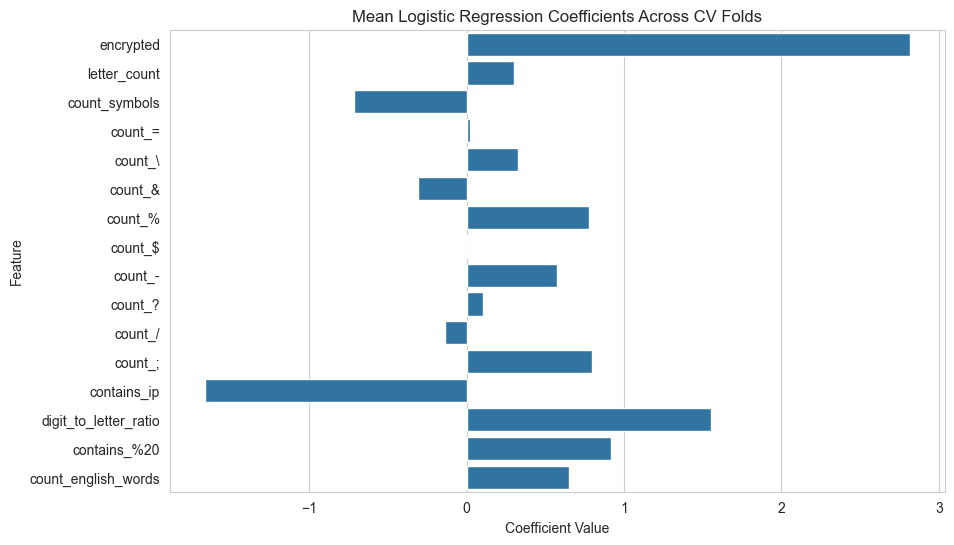

In [40]:
mean_coefs = np.mean(coefs, axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_coefs, y=X.columns, orient="h")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Mean Logistic Regression Coefficients Across CV Folds")
plt.show()

In [69]:
logistic_regression = cv_results["estimator"][best_estimator_index]
y_pred = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       0.70      0.45      0.55      1301
  defacement       0.76      0.97      0.85      1308
     malware       0.79      0.73      0.76      1255
    phishing       0.58      0.66      0.62      1340

    accuracy                           0.70      5204
   macro avg       0.71      0.70      0.69      5204
weighted avg       0.71      0.70      0.69      5204



In [42]:
cm = ConfusionMatrix(y_test.tolist(), y_pred.tolist())
cm.print_matrix()

Predict          benign           defacement       malware          phishing         
Actual
benign           588              40               113              560              

defacement       7                1269             22               10               

malware          51               211              921              72               

phishing         199              148              109              884              




### K-Nearest Neighbours

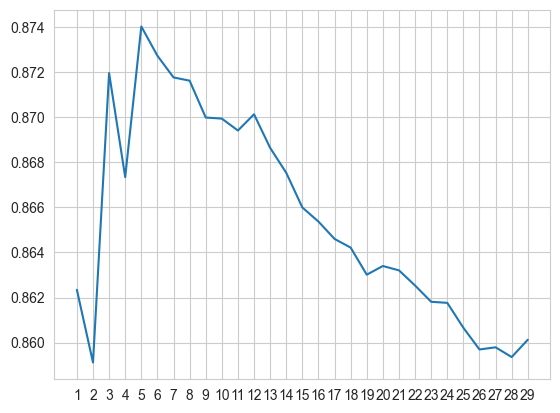

Best value for K: 5


In [43]:
knn = None
best_score = -1
scores = {}

for k in range(1, 30):
    current_model = KNeighborsClassifier(k)
    current_model.fit(X_train, y_train)

    score = current_model.score(X_val, y_val)

    if score > best_score:
        best_score = score
        knn = current_model

    scores[str(k)] = score

plt.plot(list(scores.keys()), list(scores.values()))
plt.show()

print(f"Best value for K: {knn.get_params()['n_neighbors']}")

In [44]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       0.84      0.84      0.84      1301
  defacement       0.91      0.97      0.94      1308
     malware       0.95      0.92      0.93      1255
    phishing       0.80      0.79      0.80      1340

    accuracy                           0.88      5204
   macro avg       0.88      0.88      0.88      5204
weighted avg       0.88      0.88      0.88      5204



In [45]:
cm = ConfusionMatrix(y_test.tolist(), y_pred.tolist())
cm.print_matrix()

Predict          benign           defacement       malware          phishing         
Actual
benign           1092             20               8                181              

defacement       7                1265             15               21               

malware          9                41               1151             54               

phishing         192              57               35               1056             




### Decision Tree

In [54]:
criterion = ["gini", "entropy"]
max_features = [1, "sqrt", "log2"]
max_depths = [None, 1, 2, 3, 4, 5, 8, 10, 15, 20, 50]

best_score = -1

for f, d, c in product(max_features, max_depths, criterion):
    current_model = DecisionTreeClassifier(criterion=c, max_features=f, max_depth=d)
    current_model.fit(X_train, y_train)
    y_pred = current_model.predict(X_val)

    if f1_score(y_val, y_pred, average="weighted") > best_score:
        decision_tree = current_model
        best_score = f1_score(y_val, y_pred, average="weighted")

In [55]:
y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       0.84      0.82      0.83      1301
  defacement       0.93      0.95      0.94      1308
     malware       0.96      0.93      0.94      1255
    phishing       0.77      0.80      0.79      1340

    accuracy                           0.87      5204
   macro avg       0.88      0.87      0.87      5204
weighted avg       0.87      0.87      0.87      5204



In [56]:
cm = ConfusionMatrix(y_test.tolist(), y_pred.tolist())
cm.print_matrix()

Predict          benign           defacement       malware          phishing         
Actual
benign           1071             13               4                213              

defacement       9                1240             14               45               

malware          9                28               1162             56               

phishing         180              55               34               1071             




### Random Forest

In [59]:
criterion = ["gini", "entropy"]
n_estimators = [1, 2, 5, 10, 20, 50, 100, 200]
max_features = [1, "sqrt", "log2"]
max_depths = [None, 1, 2, 4, 8, 10, 15, 20]

best_score = -1

for n, f, d, c in product(n_estimators, max_features, max_depths, criterion):
    current_model = RandomForestClassifier(n_estimators=n, criterion=c, max_features=f, max_depth=d)
    current_model.fit(X_train, y_train)
    y_pred = current_model.predict(X_val)

    if f1_score(y_val, y_pred, average="weighted") > best_score:
        random_forest = current_model
        best_score = f1_score(y_val, y_pred, average="weighted")

In [60]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       0.87      0.87      0.87      1301
  defacement       0.93      0.98      0.95      1308
     malware       0.97      0.93      0.95      1255
    phishing       0.83      0.82      0.83      1340

    accuracy                           0.90      5204
   macro avg       0.90      0.90      0.90      5204
weighted avg       0.90      0.90      0.90      5204



In [61]:
cm = ConfusionMatrix(y_test.tolist(), y_pred.tolist())
cm.print_matrix()

Predict          benign           defacement       malware          phishing         
Actual
benign           1132             12               3                154              

defacement       5                1276             9                18               

malware          6                32               1166             51               

phishing         161              52               22               1105             




### Gradient Boosting

In [62]:
parameters = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100],
    "max_depth": [2, 3, 4, 5, 6]
}

In [63]:
gradient_boosting = GridSearchCV(
    GradientBoostingClassifier(),
    parameters
)

gradient_boosting.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [1, 2, 5, 10, 20, 50, 100]})

In [64]:
y_pred = gradient_boosting.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       0.85      0.86      0.85      1301
  defacement       0.90      0.96      0.93      1308
     malware       0.95      0.89      0.92      1255
    phishing       0.81      0.79      0.80      1340

    accuracy                           0.88      5204
   macro avg       0.88      0.88      0.88      5204
weighted avg       0.88      0.88      0.87      5204



In [65]:
cm = ConfusionMatrix(y_test.tolist(), y_pred.tolist())
cm.print_matrix()

Predict          benign           defacement       malware          phishing         
Actual
benign           1119             16               5                161              

defacement       7                1260             22               19               

malware          6                62               1123             64               

phishing         189              62               37               1052             




## Overall Evaluation

In [66]:
def evaluate_model(model, X_test, y_test, X_val, y_val):
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred, average="weighted")
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1_score = f1_score(y_val, y_val_pred, average="weighted")
    return test_accuracy, test_f1_score, val_accuracy, val_f1_score

In [70]:
models = [logistic_regression, knn, decision_tree, random_forest, gradient_boosting]

results = []
for model in models:
    test_accuracy, test_f1_score, val_accuracy, val_f1_score = evaluate_model(model, X_test, y_test, X_val, y_val)
    results.append({
        "Model": str(model),
        "Validation Accuracy": val_accuracy,
        "Validation F1 Score": val_f1_score,
        "Test Accuracy": test_accuracy,
        "Test F1 Score": test_f1_score
    })
results_df = pd.DataFrame(results)
results_df

,Model,Validation Accuracy,Validation F1 Score,Test Accuracy,Test F1 Score
0,"LogisticRegression(max_iter=10000, random_stat...",0.688785,0.677855,0.703689,0.693758
1,KNeighborsClassifier(),0.874015,0.873288,0.877018,0.876595
2,"DecisionTreeClassifier(criterion='entropy', ma...",0.874592,0.874498,0.873174,0.873523
3,"RandomForestClassifier(criterion='entropy', ma...",0.897223,0.896652,0.899116,0.898985
4,GridSearchCV(estimator=GradientBoostingClassif...,0.876706,0.875917,0.875096,0.874614
